<a href="https://colab.research.google.com/github/Abhinavl3v3l/EVA6/blob/main/EVA6Session7_Early.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [8]:
!nvidia-smi

Tue Jun 22 22:33:30 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 465.27       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P8     9W /  70W |      3MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [9]:
! pip install albumentations==0.4.6 -q

In [10]:
import albumentations
albumentations.__version__

'0.4.6'

In [11]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from torchsummary import summary

%matplotlib inline
import matplotlib.pyplot as plt
import pickle
import numpy as np

## YetAnotherDeepLearning Library

In [12]:
!git clone https://github.com/Abhinavl3v3l/EVA6.git
%cd "EVA6/s7"
!pwd

Cloning into 'EVA6'...
remote: Enumerating objects: 82, done.
remote: Counting objects: 100% (82/82), done.
remote: Compressing objects: 100% (74/74), done.
remote: Total 82 (delta 11), reused 71 (delta 6), pack-reused 0
Unpacking objects: 100% (82/82), done.
/content/EVA6/s7/EVA6/s7
/content/EVA6/s7/EVA6/s7


In [13]:
## Importing stuff from YetAnotherDeepLearning Library
from yadl.data import get_dataloaders
from yadl.model import Net
from yadl.train import train, get_optimizer
from yadl.test import test
from yadl.utils import get_misclassified, plot_single, plot_multi

## Looking at the data

In [14]:
from yadl.data import Cifar10Dataset
from yadl.transformations import get_train_test_transforms


In [15]:
def train_data_details(cols=8, rows=5, transform=None):
  cifar10_ex = Cifar10Dataset('./data', train=True, download=True, transform=transform, viz=True )
  figure = plt.figure(figsize=(cols*1.5, rows*1.5))
  for i in range(1, cols * rows + 1):
    img, label = cifar10_ex[i]

    figure.add_subplot(rows, cols, i)
    plt.title(cifar10_ex.classes[label])
    plt.axis("off")
    # if transform is not None:
    #   plt.imshow(img.astype('uint8'))
    # else:
    plt.imshow(img, cmap="gray")

  plt.tight_layout()
  plt.show()
  if transform is None:
    print(' - mean:', np.mean(cifar10_ex.data, axis=(0,1,2)) / 255.)
    print(' - std:', np.std(cifar10_ex.data, axis=(0,1,2)) / 255.)
    print(' - var:', np.var(cifar10_ex.data, axis=(0,1,2)) / 255.)
  return cifar10_ex.classes



Extracting ./data/cifar-10-python.tar.gz to ./data


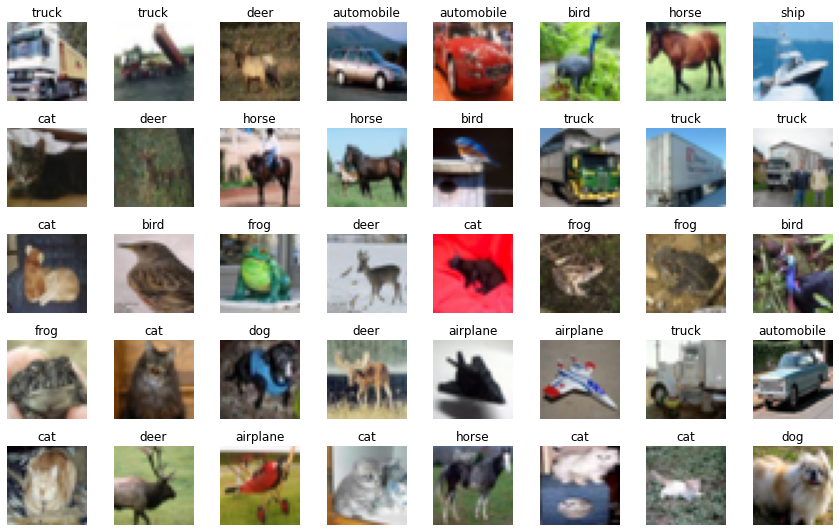

 - mean: [0.49139968 0.48215841 0.44653091]
 - std: [0.24703223 0.24348513 0.26158784]
 - var: [15.56135559 15.11767693 17.44919073]


In [16]:
classes = train_data_details()

In [17]:
classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

## After transformations and normalization

Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

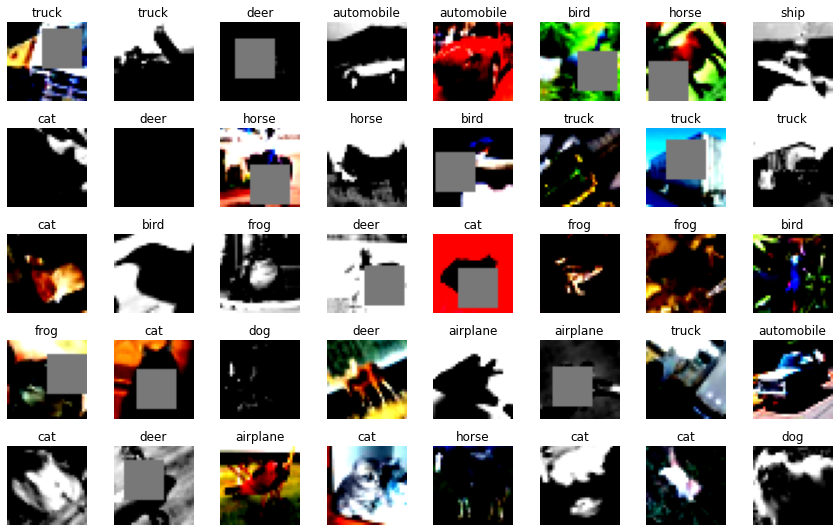

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [18]:
train_transforms, test_transforms = get_train_test_transforms()
train_data_details(transform=train_transforms)

In [19]:
# cifar10_ex.classes


## Trainer

In [20]:
EPOCHS = 20

SEED = 69
use_cuda = torch.cuda.is_available()

torch.manual_seed(SEED)
if use_cuda:
    torch.cuda.manual_seed(SEED)

device = torch.device("cuda" if use_cuda else "cpu")

In [21]:
def train_model(model, name, MAX_LR = 0.2, EPOCHS = 20, train_batch_size=128, val_batch_size=128, ):
  train_losses = []
  test_losses = []
  train_acc = []
  test_accs = []

  train_loader, test_loader = get_dataloaders(train_batch_size=train_batch_size,
                                              val_batch_size=val_batch_size,)

  print("*****A bit of Model Summary*****")
  summary(model, input_size=(3, 32, 32))

  wd = 0

  optimizer = get_optimizer(model.parameters(), lr=0.01, momentum=0.9, weight_decay=wd)

  scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, 
                                                max_lr=MAX_LR,
                                                steps_per_epoch=len(train_loader),
                                                epochs=EPOCHS) 

  print("*****Training Start*****")
  for epoch in range(EPOCHS):
      print('EPOCH {} and Learning Rate {}: '.format(epoch+1, scheduler.get_last_lr()))
      train_epoch_losses, train_epoch_acc = train(model, device, train_loader, optimizer, scheduler)
      test_loss, test_acc = test(model, device, test_loader)
      train_losses.extend(train_epoch_losses)
      train_acc.extend(train_epoch_acc)
      test_losses.append(test_loss)
      test_accs.append(test_acc)

  torch.save(model.state_dict(), f"{name}.pth")

  plot_single(name, train_losses, train_acc, test_losses, test_accs)
  return model, train_losses, test_losses, train_acc, test_accs

# Training and Stuff

Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


*****A bit of Model Summary*****


  0%|          | 0/782 [00:00<?, ?it/s]

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 32, 32]             864
              ReLU-2           [-1, 32, 32, 32]               0
       BatchNorm2d-3           [-1, 32, 32, 32]              64
            Conv2d-4           [-1, 32, 32, 32]             288
            Conv2d-5           [-1, 64, 32, 32]           2,048
              ReLU-6           [-1, 64, 32, 32]               0
       BatchNorm2d-7           [-1, 64, 32, 32]             128
            Conv2d-8           [-1, 32, 32, 32]           2,048
            Conv2d-9           [-1, 32, 32, 32]           9,216
             ReLU-10           [-1, 32, 32, 32]               0
      BatchNorm2d-11           [-1, 32, 32, 32]              64
           Conv2d-12           [-1, 32, 32, 32]             288
           Conv2d-13           [-1, 64, 32, 32]           2,048
             ReLU-14           [-1, 64,

Loss=1.704555630683899 Batch_id=781 Accuracy=36.85: 100%|██████████| 782/782 [00:17<00:00, 43.68it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 1.3221, Accuracy: 5342/10000 (53.42%)

EPOCH 2 and Learning Rate [0.008821380710680227]: 


Loss=1.8083099126815796 Batch_id=781 Accuracy=48.26: 100%|██████████| 782/782 [00:17<00:00, 43.91it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 1.1101, Accuracy: 5999/10000 (59.99%)

EPOCH 3 and Learning Rate [0.011271467295390108]: 


Loss=1.4131355285644531 Batch_id=781 Accuracy=52.25: 100%|██████████| 782/782 [00:17<00:00, 43.46it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 1.0224, Accuracy: 6407/10000 (64.07%)

EPOCH 4 and Learning Rate [0.015308333632042648]: 


Loss=1.084452509880066 Batch_id=781 Accuracy=55.29: 100%|██████████| 782/782 [00:17<00:00, 43.78it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 1.0403, Accuracy: 6489/10000 (64.89%)

EPOCH 5 and Learning Rate [0.020862900467710305]: 


Loss=1.210052251815796 Batch_id=781 Accuracy=57.33: 100%|██████████| 782/782 [00:17<00:00, 43.72it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.8381, Accuracy: 7075/10000 (70.75%)

EPOCH 6 and Learning Rate [0.02784011750958057]: 


Loss=1.396032691001892 Batch_id=781 Accuracy=59.01: 100%|██████████| 782/782 [00:17<00:00, 43.47it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.9898, Accuracy: 6582/10000 (65.82%)

EPOCH 7 and Learning Rate [0.036120589934894615]: 


Loss=0.9121749401092529 Batch_id=781 Accuracy=59.86: 100%|██████████| 782/782 [00:18<00:00, 42.65it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.8827, Accuracy: 6940/10000 (69.40%)

EPOCH 8 and Learning Rate [0.04556262148687182]: 


Loss=0.6894054412841797 Batch_id=781 Accuracy=61.69: 100%|██████████| 782/782 [00:18<00:00, 42.20it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.8508, Accuracy: 7009/10000 (70.09%)

EPOCH 9 and Learning Rate [0.05600463919496154]: 


Loss=0.9320715665817261 Batch_id=781 Accuracy=62.15: 100%|██████████| 782/782 [00:18<00:00, 43.12it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.7640, Accuracy: 7308/10000 (73.08%)

EPOCH 10 and Learning Rate [0.06726795822737208]: 


Loss=0.8345093727111816 Batch_id=781 Accuracy=63.47: 100%|██████████| 782/782 [00:18<00:00, 43.31it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.7882, Accuracy: 7315/10000 (73.15%)

EPOCH 11 and Learning Rate [0.07915983956344792]: 


Loss=0.8684160113334656 Batch_id=781 Accuracy=64.08: 100%|██████████| 782/782 [00:17<00:00, 44.09it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.7387, Accuracy: 7510/10000 (75.10%)

EPOCH 12 and Learning Rate [0.09147678816270682]: 


Loss=1.3550952672958374 Batch_id=781 Accuracy=64.80: 100%|██████████| 782/782 [00:18<00:00, 42.90it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.8882, Accuracy: 7141/10000 (71.41%)

EPOCH 13 and Learning Rate [0.10400803519194311]: 


Loss=0.48519203066825867 Batch_id=781 Accuracy=65.07: 100%|██████████| 782/782 [00:18<00:00, 42.38it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6953, Accuracy: 7625/10000 (76.25%)

EPOCH 14 and Learning Rate [0.1165391447221863]: 


Loss=0.7630239129066467 Batch_id=781 Accuracy=66.06: 100%|██████████| 782/782 [00:18<00:00, 42.91it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.7049, Accuracy: 7610/10000 (76.10%)

EPOCH 15 and Learning Rate [0.12885568317736218]: 


Loss=0.8257523775100708 Batch_id=781 Accuracy=66.25: 100%|██████████| 782/782 [00:18<00:00, 43.01it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6946, Accuracy: 7635/10000 (76.35%)

EPOCH 16 and Learning Rate [0.14074688874269087]: 


Loss=1.1338543891906738 Batch_id=781 Accuracy=66.84: 100%|██████████| 782/782 [00:18<00:00, 42.84it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.7208, Accuracy: 7510/10000 (75.10%)

EPOCH 17 and Learning Rate [0.1520092779415454]: 


Loss=0.8037002086639404 Batch_id=781 Accuracy=67.41: 100%|██████████| 782/782 [00:18<00:00, 42.75it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.7474, Accuracy: 7525/10000 (75.25%)

EPOCH 18 and Learning Rate [0.1624501276646735]: 


Loss=0.9242201447486877 Batch_id=781 Accuracy=67.61: 100%|██████████| 782/782 [00:18<00:00, 42.37it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6156, Accuracy: 7838/10000 (78.38%)

EPOCH 19 and Learning Rate [0.17189077306695658]: 


Loss=1.0676714181900024 Batch_id=781 Accuracy=68.21: 100%|██████████| 782/782 [00:18<00:00, 42.91it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6152, Accuracy: 7870/10000 (78.70%)

EPOCH 20 and Learning Rate [0.18016966489777372]: 


Loss=1.0404162406921387 Batch_id=781 Accuracy=68.68: 100%|██████████| 782/782 [00:18<00:00, 42.30it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6881, Accuracy: 7670/10000 (76.70%)

EPOCH 21 and Learning Rate [0.18714513394763235]: 


Loss=1.035074234008789 Batch_id=781 Accuracy=68.68: 100%|██████████| 782/782 [00:18<00:00, 43.04it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6232, Accuracy: 7911/10000 (79.11%)

EPOCH 22 and Learning Rate [0.19269781530558455]: 


Loss=1.2106651067733765 Batch_id=781 Accuracy=69.22: 100%|██████████| 782/782 [00:18<00:00, 43.06it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6612, Accuracy: 7787/10000 (77.87%)

EPOCH 23 and Learning Rate [0.1967326909432975]: 


Loss=0.6515897512435913 Batch_id=781 Accuracy=69.12: 100%|██████████| 782/782 [00:18<00:00, 41.94it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6327, Accuracy: 7836/10000 (78.36%)

EPOCH 24 and Learning Rate [0.1991807156728793]: 


Loss=0.4665278196334839 Batch_id=781 Accuracy=69.48: 100%|██████████| 782/782 [00:18<00:00, 41.84it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5962, Accuracy: 7953/10000 (79.53%)

EPOCH 25 and Learning Rate [0.1999999997426771]: 


Loss=0.8151899576187134 Batch_id=781 Accuracy=69.86: 100%|██████████| 782/782 [00:18<00:00, 42.39it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5713, Accuracy: 8048/10000 (80.48%)

EPOCH 26 and Learning Rate [0.19984227963217474]: 


Loss=1.3268846273422241 Batch_id=781 Accuracy=70.14: 100%|██████████| 782/782 [00:18<00:00, 42.36it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6117, Accuracy: 7895/10000 (78.95%)

EPOCH 27 and Learning Rate [0.19937042003041172]: 


Loss=0.6659584641456604 Batch_id=781 Accuracy=70.46: 100%|██████████| 782/782 [00:18<00:00, 42.27it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6033, Accuracy: 7981/10000 (79.81%)

EPOCH 28 and Learning Rate [0.1985859055822665]: 


Loss=0.8141312599182129 Batch_id=781 Accuracy=70.33: 100%|██████████| 782/782 [00:18<00:00, 41.46it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5411, Accuracy: 8159/10000 (81.59%)

EPOCH 29 and Learning Rate [0.19749120466043535]: 


Loss=0.9965587258338928 Batch_id=781 Accuracy=71.13: 100%|██████████| 782/782 [00:18<00:00, 42.43it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5512, Accuracy: 8091/10000 (80.91%)

EPOCH 30 and Learning Rate [0.1960897615990186]: 


Loss=0.8946143388748169 Batch_id=781 Accuracy=70.69: 100%|██████████| 782/782 [00:18<00:00, 41.77it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5549, Accuracy: 8090/10000 (80.90%)

EPOCH 31 and Learning Rate [0.19438598585637154]: 


Loss=1.1194913387298584 Batch_id=781 Accuracy=71.37: 100%|██████████| 782/782 [00:18<00:00, 42.07it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5697, Accuracy: 8076/10000 (80.76%)

EPOCH 32 and Learning Rate [0.19238523814131678]: 


Loss=0.92571622133255 Batch_id=781 Accuracy=71.13: 100%|██████████| 782/782 [00:18<00:00, 42.34it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5848, Accuracy: 8027/10000 (80.27%)

EPOCH 33 and Learning Rate [0.19009381354637134]: 


Loss=0.5450011491775513 Batch_id=781 Accuracy=71.74: 100%|██████████| 782/782 [00:18<00:00, 42.36it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5828, Accuracy: 8017/10000 (80.17%)

EPOCH 34 and Learning Rate [0.18751892174105628]: 


Loss=0.6491289138793945 Batch_id=781 Accuracy=71.93: 100%|██████████| 782/782 [00:18<00:00, 42.29it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5609, Accuracy: 8098/10000 (80.98%)

EPOCH 35 and Learning Rate [0.1846686642876094]: 


  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6320, Accuracy: 7931/10000 (79.31%)

EPOCH 36 and Learning Rate [0.18155200915047287]: 


Loss=0.8662495613098145 Batch_id=781 Accuracy=72.39: 100%|██████████| 782/782 [00:18<00:00, 42.20it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5552, Accuracy: 8100/10000 (81.00%)

EPOCH 37 and Learning Rate [0.17817876247975953]: 


Loss=1.5368355512619019 Batch_id=781 Accuracy=72.46: 100%|██████████| 782/782 [00:18<00:00, 42.33it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5481, Accuracy: 8179/10000 (81.79%)

EPOCH 38 and Learning Rate [0.17455953775747649]: 


Loss=0.7836781740188599 Batch_id=781 Accuracy=72.61: 100%|██████████| 782/782 [00:18<00:00, 41.88it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.6096, Accuracy: 8047/10000 (80.47%)

EPOCH 39 and Learning Rate [0.17070572240358423]: 


Loss=0.6168472766876221 Batch_id=781 Accuracy=72.64: 100%|██████████| 782/782 [00:18<00:00, 42.77it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5072, Accuracy: 8304/10000 (83.04%)

EPOCH 40 and Learning Rate [0.16662944194696044]: 


Loss=0.7412835955619812 Batch_id=781 Accuracy=72.69: 100%|██████████| 782/782 [00:18<00:00, 42.45it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4947, Accuracy: 8321/10000 (83.21%)

EPOCH 41 and Learning Rate [0.1623435218740002]: 


Loss=0.44545871019363403 Batch_id=781 Accuracy=73.02: 100%|██████████| 782/782 [00:18<00:00, 42.15it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5393, Accuracy: 8208/10000 (82.08%)

EPOCH 42 and Learning Rate [0.15786144727489076]: 


Loss=0.48593392968177795 Batch_id=781 Accuracy=73.18: 100%|██████████| 782/782 [00:18<00:00, 42.15it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5208, Accuracy: 8256/10000 (82.56%)

EPOCH 43 and Learning Rate [0.15319732041452877]: 


Loss=0.6126440763473511 Batch_id=781 Accuracy=73.59: 100%|██████████| 782/782 [00:18<00:00, 42.00it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5531, Accuracy: 8185/10000 (81.85%)

EPOCH 44 and Learning Rate [0.14836581636157772]: 


Loss=0.7224835157394409 Batch_id=781 Accuracy=73.49: 100%|██████████| 782/782 [00:18<00:00, 42.32it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4906, Accuracy: 8338/10000 (83.38%)

EPOCH 45 and Learning Rate [0.14338213681527248]: 


Loss=0.8863941431045532 Batch_id=781 Accuracy=73.72: 100%|██████████| 782/782 [00:18<00:00, 41.82it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4873, Accuracy: 8380/10000 (83.80%)

EPOCH 46 and Learning Rate [0.13826196227524962]: 


Loss=0.9908604621887207 Batch_id=781 Accuracy=73.84: 100%|██████████| 782/782 [00:18<00:00, 41.63it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5052, Accuracy: 8313/10000 (83.13%)

EPOCH 47 and Learning Rate [0.13302140270489415]: 


Loss=0.7740862965583801 Batch_id=781 Accuracy=74.01: 100%|██████████| 782/782 [00:18<00:00, 42.34it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5063, Accuracy: 8312/10000 (83.12%)

EPOCH 48 and Learning Rate [0.1276769468434347]: 


Loss=0.9442899227142334 Batch_id=781 Accuracy=74.18: 100%|██████████| 782/782 [00:18<00:00, 42.20it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4661, Accuracy: 8416/10000 (84.16%)

EPOCH 49 and Learning Rate [0.12224541032626969]: 


Loss=1.4501101970672607 Batch_id=781 Accuracy=74.14: 100%|██████████| 782/782 [00:18<00:00, 42.64it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5560, Accuracy: 8148/10000 (81.48%)

EPOCH 50 and Learning Rate [0.11674388277675708]: 


Loss=0.6277572512626648 Batch_id=781 Accuracy=74.37: 100%|██████████| 782/782 [00:18<00:00, 42.47it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5179, Accuracy: 8313/10000 (83.13%)

EPOCH 51 and Learning Rate [0.1111896740359368]: 


Loss=0.8791764378547668 Batch_id=781 Accuracy=74.57: 100%|██████████| 782/782 [00:18<00:00, 41.81it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.5055, Accuracy: 8365/10000 (83.65%)

EPOCH 52 and Learning Rate [0.10560025969936676]: 


Loss=0.6227606534957886 Batch_id=781 Accuracy=74.62: 100%|██████████| 782/782 [00:18<00:00, 42.66it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4620, Accuracy: 8437/10000 (84.37%)

EPOCH 53 and Learning Rate [0.09999322613243396]: 


Loss=1.1841871738433838 Batch_id=781 Accuracy=74.95: 100%|██████████| 782/782 [00:18<00:00, 41.77it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4920, Accuracy: 8358/10000 (83.58%)

EPOCH 54 and Learning Rate [0.09438621513714264]: 


Loss=1.3344155550003052 Batch_id=781 Accuracy=75.13: 100%|██████████| 782/782 [00:18<00:00, 42.02it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4618, Accuracy: 8411/10000 (84.11%)

EPOCH 55 and Learning Rate [0.08879686844447815]: 


Loss=1.1923975944519043 Batch_id=781 Accuracy=75.06: 100%|██████████| 782/782 [00:18<00:00, 42.29it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4582, Accuracy: 8447/10000 (84.47%)

EPOCH 56 and Learning Rate [0.0832427722069948]: 


Loss=0.6274233460426331 Batch_id=781 Accuracy=75.81: 100%|██████████| 782/782 [00:18<00:00, 41.48it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4540, Accuracy: 8475/10000 (84.75%)

EPOCH 57 and Learning Rate [0.07774140166627344]: 


Loss=0.5452152490615845 Batch_id=781 Accuracy=75.74: 100%|██████████| 782/782 [00:18<00:00, 42.12it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4630, Accuracy: 8443/10000 (84.43%)

EPOCH 58 and Learning Rate [0.07231006616934618]: 


Loss=0.9580586552619934 Batch_id=781 Accuracy=75.71: 100%|██████████| 782/782 [00:18<00:00, 42.15it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4673, Accuracy: 8453/10000 (84.53%)

EPOCH 59 and Learning Rate [0.066965854707087]: 


Loss=1.0038752555847168 Batch_id=781 Accuracy=75.87: 100%|██████████| 782/782 [00:18<00:00, 42.03it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4704, Accuracy: 8400/10000 (84.00%)

EPOCH 60 and Learning Rate [0.06172558214592398]: 


Loss=0.9688518047332764 Batch_id=781 Accuracy=76.45: 100%|██████████| 782/782 [00:18<00:00, 41.81it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4543, Accuracy: 8463/10000 (84.63%)

EPOCH 61 and Learning Rate [0.056605736322048614]: 


Loss=0.5355124473571777 Batch_id=781 Accuracy=76.35: 100%|██████████| 782/782 [00:18<00:00, 41.30it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4425, Accuracy: 8491/10000 (84.91%)

EPOCH 62 and Learning Rate [0.05162242616458335]: 


Loss=1.125573754310608 Batch_id=781 Accuracy=76.73: 100%|██████████| 782/782 [00:18<00:00, 41.84it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4258, Accuracy: 8524/10000 (85.24%)

EPOCH 63 and Learning Rate [0.04679133101093077]: 


Loss=1.1463186740875244 Batch_id=781 Accuracy=77.02: 100%|██████████| 782/782 [00:18<00:00, 41.67it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4307, Accuracy: 8551/10000 (85.51%)

EPOCH 64 and Learning Rate [0.04212765127377732]: 


Loss=1.1184437274932861 Batch_id=781 Accuracy=77.15: 100%|██████████| 782/782 [00:18<00:00, 42.16it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4269, Accuracy: 8513/10000 (85.13%)

EPOCH 65 and Learning Rate [0.037646060614971416]: 


Loss=0.6193357110023499 Batch_id=781 Accuracy=76.72: 100%|██████████| 782/782 [00:18<00:00, 41.75it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4240, Accuracy: 8558/10000 (85.58%)

EPOCH 66 and Learning Rate [0.03336065977675451]: 


Loss=0.46617552638053894 Batch_id=781 Accuracy=77.40: 100%|██████████| 782/782 [00:18<00:00, 41.72it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4273, Accuracy: 8542/10000 (85.42%)

EPOCH 67 and Learning Rate [0.029284932215609218]: 


Loss=1.0805134773254395 Batch_id=781 Accuracy=77.50: 100%|██████████| 782/782 [00:18<00:00, 42.20it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4245, Accuracy: 8555/10000 (85.55%)

EPOCH 68 and Learning Rate [0.02543170167831689]: 


Loss=0.5218173265457153 Batch_id=781 Accuracy=77.74: 100%|██████████| 782/782 [00:18<00:00, 41.29it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4148, Accuracy: 8570/10000 (85.70%)

EPOCH 69 and Learning Rate [0.021813091853705845]: 


Loss=0.5977577567100525 Batch_id=781 Accuracy=78.02: 100%|██████████| 782/782 [00:18<00:00, 41.72it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4122, Accuracy: 8617/10000 (86.17%)

EPOCH 70 and Learning Rate [0.018440488227041]: 


Loss=0.6212405562400818 Batch_id=781 Accuracy=78.13: 100%|██████████| 782/782 [00:18<00:00, 41.58it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4070, Accuracy: 8621/10000 (86.21%)

EPOCH 71 and Learning Rate [0.015324502257075004]: 


Loss=0.819345235824585 Batch_id=781 Accuracy=78.16: 100%|██████████| 782/782 [00:18<00:00, 41.28it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4022, Accuracy: 8631/10000 (86.31%)

EPOCH 72 and Learning Rate [0.012474937988473146]: 


Loss=0.42450496554374695 Batch_id=781 Accuracy=78.68: 100%|██████████| 782/782 [00:18<00:00, 41.79it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4050, Accuracy: 8623/10000 (86.23%)

EPOCH 73 and Learning Rate [0.009900761204661693]: 


Loss=0.8377923369407654 Batch_id=781 Accuracy=78.97: 100%|██████████| 782/782 [00:18<00:00, 41.73it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4049, Accuracy: 8615/10000 (86.15%)

EPOCH 74 and Learning Rate [0.007610071218156189]: 


Loss=0.3178037405014038 Batch_id=781 Accuracy=79.23: 100%|██████████| 782/782 [00:18<00:00, 41.45it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.4076, Accuracy: 8613/10000 (86.13%)

EPOCH 75 and Learning Rate [0.005610075387127873]: 


Loss=0.6278717517852783 Batch_id=781 Accuracy=79.13: 100%|██████████| 782/782 [00:18<00:00, 42.04it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.3981, Accuracy: 8638/10000 (86.38%)

EPOCH 76 and Learning Rate [0.003907066438388321]: 


Loss=0.6552791595458984 Batch_id=781 Accuracy=79.16: 100%|██████████| 782/782 [00:18<00:00, 41.45it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.3883, Accuracy: 8668/10000 (86.68%)

EPOCH 77 and Learning Rate [0.0025064026681429217]: 


Loss=0.42427679896354675 Batch_id=781 Accuracy=79.14: 100%|██████████| 782/782 [00:18<00:00, 41.58it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.3858, Accuracy: 8679/10000 (86.79%)

EPOCH 78 and Learning Rate [0.0014124910828085392]: 


Loss=0.22607332468032837 Batch_id=781 Accuracy=79.36: 100%|██████████| 782/782 [00:18<00:00, 41.59it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.3856, Accuracy: 8690/10000 (86.90%)

EPOCH 79 and Learning Rate [0.0006287735329409451]: 


Loss=0.6430982351303101 Batch_id=781 Accuracy=79.58: 100%|██████████| 782/782 [00:18<00:00, 41.53it/s]
  0%|          | 0/782 [00:00<?, ?it/s]


Test set: Average loss: 0.3869, Accuracy: 8684/10000 (86.84%)

EPOCH 80 and Learning Rate [0.00015771588389959499]: 


Loss=0.6595807075500488 Batch_id=781 Accuracy=79.43: 100%|██████████| 782/782 [00:18<00:00, 41.97it/s]



Test set: Average loss: 0.3931, Accuracy: 8652/10000 (86.52%)



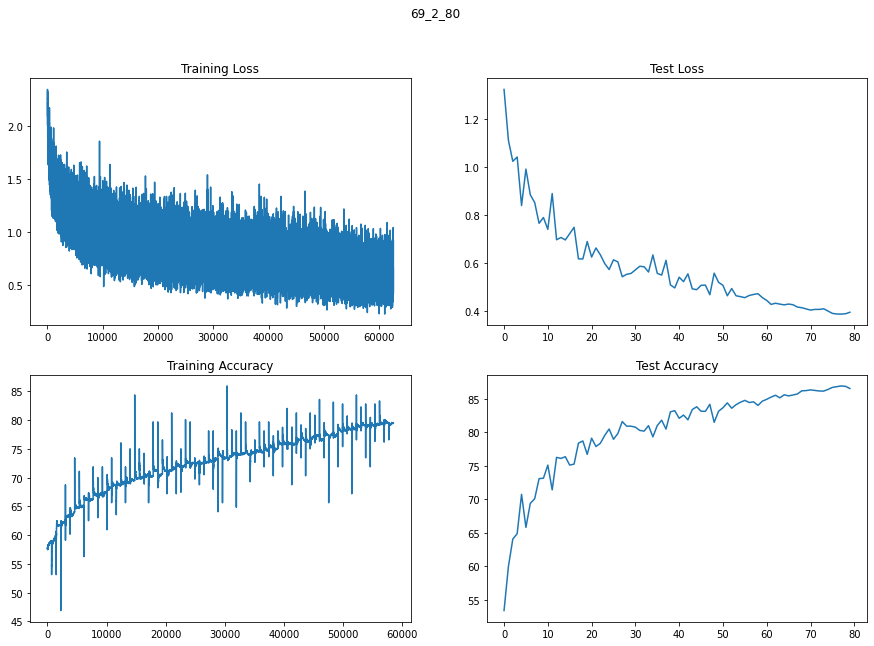

In [22]:
model =  Net().to(device)

model, train_losses, test_losses, train_acc, test_accs = train_model(model, "69_2_80", 
                                                                     MAX_LR = 0.2, EPOCHS = 80,
                                                                     train_batch_size = 64,
                                                                     val_batch_size = 64)

Files already downloaded and verified
Files already downloaded and verified


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integ

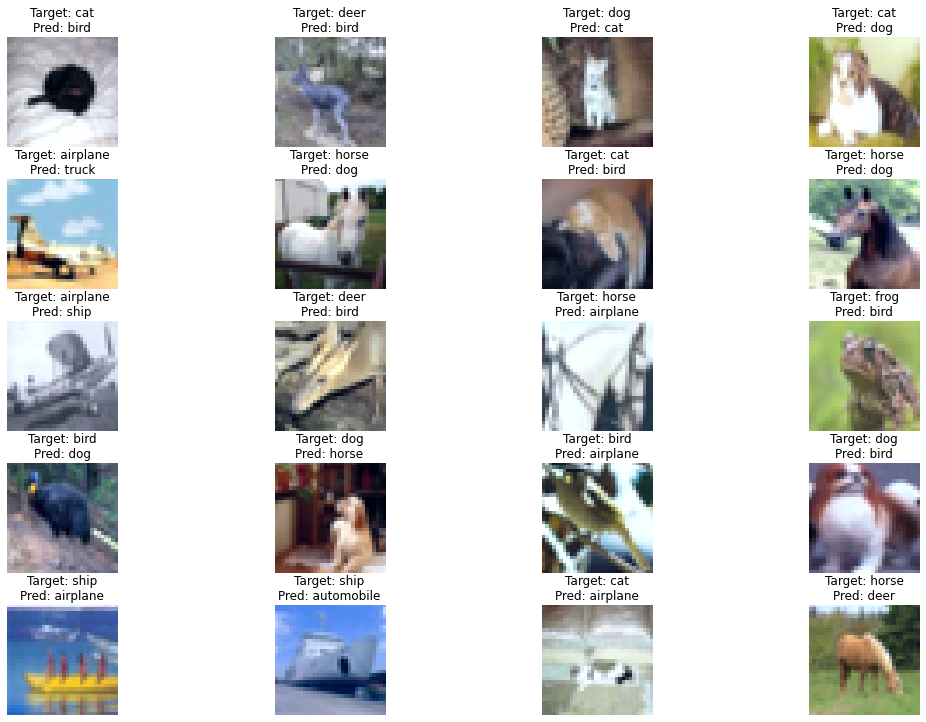

In [23]:
get_misclassified(model, "69_2_80", classes)
